# Sentiment neuron

Do we have a neuron (across all layers) that encodes "sentiment" (positive vs. negative)?

To find this out, we train a classifier to predict the sentiment from activations of the model while reading the product review text.


### Install packages

In [1]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
!pip install transformers

In [3]:
# https://github.com/huggingface/datasets/issues/5406
%pip install datasets==2.5.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 10.7 MB/s eta 0:00:00


In [4]:
%pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.1 MB/s eta 0:00:00


In [5]:
!pip install -i https://pypi.org/simple/ bitsandbytes

Looking in indexes: https://pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.4 MB/s eta 0:00:00


In [6]:
!pip install tqdm

In [7]:
%load_ext autoreload
%autoreload 2

## Load a pre-trained model

In [8]:
from tqdm import tqdm

import torch
import torch.nn as nn

from transformers import AutoModelForCausalLM, AutoTokenizer

In [9]:
model_name = 'tiiuae/falcon-7b'
# model_name = "EleutherAI/pythia-2.8b"
# model_name = "EleutherAI/pythia-6.9b"


model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_8bit=True,
    output_hidden_states=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

In [11]:
# check model configurations
print(model)

FalconForCausalLM(
  (transformer): FalconModel(
    (word_embeddings): Embedding(65024, 4544)
    (h): ModuleList(
      (0-31): 32 x FalconDecoderLayer(
        (self_attention): FalconAttention(
          (rotary_emb): FalconRotaryEmbedding()
          (query_key_value): Linear8bitLt(in_features=4544, out_features=4672, bias=False)
          (dense): Linear8bitLt(in_features=4544, out_features=4544, bias=False)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): FalconMLP(
          (dense_h_to_4h): Linear8bitLt(in_features=4544, out_features=18176, bias=False)
          (act): GELUActivation()
          (dense_4h_to_h): Linear8bitLt(in_features=18176, out_features=4544, bias=False)
        )
        (input_layernorm): LayerNorm((4544,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_f): LayerNorm((4544,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=4544, out_features=65024, bias=False)
)


In [12]:
num_layers = 32
hidden_dim = 4544

## Create a dataset for sentiment classification

In [13]:
# Load dataset

from datasets import load_dataset, DatasetDict

# dataset_name = "stanfordnlp/imdb"

dataset_name = "fancyzhx/yelp_polarity"

review_dataset = load_dataset(dataset_name)

review_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset yelp_polarity downloaded and prepared to /root/.cache/huggingface/datasets/fancyzhx___yelp_polarity/plain_text/1.0.0/14f90415c754f47cf9087eadac25823a395fef4400c7903c5897f55cfaaa6f61. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 38000
    })
})

In [14]:
truncation_length = 300

def truncate(example):
    return {
        'text': " ".join(example['text'].split()[:truncation_length]),
        'label': example['label']
    }

In [15]:
num_datapoints = 500

small_review_dataset = DatasetDict(
    train=review_dataset['train'].shuffle(seed=1111).select(range(num_datapoints)).map(truncate),
    valid=review_dataset['train'].shuffle(seed=1111).select(range(num_datapoints, num_datapoints * 2)).map(truncate),
    test=review_dataset['test'].shuffle(seed=1111).select(range(num_datapoints)).map(truncate),
)
small_review_dataset

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
})

In [16]:
tokenizer.add_special_tokens({'pad_token': f'{tokenizer.eos_token}'})

0

In [17]:
small_tokenized_dataset = small_review_dataset.map(
    lambda example: tokenizer(example['text'], padding=True, truncation=True), # https://huggingface.co/docs/transformers/pad_truncation
    batched=True,
    batch_size=16
)

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

In [18]:
from torch.utils.data import DataLoader

batch_size = 1
dataloader = {}

dataloader['train'] = DataLoader(small_tokenized_dataset['train'], batch_size=batch_size)
dataloader['valid'] = DataLoader(small_tokenized_dataset['valid'], batch_size=batch_size)
dataloader['test'] = DataLoader(small_tokenized_dataset['test'], batch_size=batch_size)

In [19]:
torch.set_grad_enabled(False)

In [20]:
output_per_layer = {}
label_list = []

for layer_id in range(num_layers):
  output_per_layer[layer_id] = []

dataloader_layer_wise = {}

for data_split in ['train', 'valid', 'test']:
    output_per_layer = {}
    label_list = []
    dataloader_layer_wise[data_split] = {}

    for layer_id in range(num_layers):
        output_per_layer[layer_id] = []

    for batch_i, batch in enumerate(tqdm(dataloader[data_split])):

        with torch.no_grad():
            output = model(torch.stack(batch['input_ids'], dim=0).to('cuda'))['hidden_states']
        for layer_id in range(num_layers):
            output_per_layer[layer_id].append(output[layer_id+1].max(0)[0].to('cpu'))  # +1 to skip the embedding layer; mean(0) to be average over the positions
        label_list.append(batch['label'].to('cpu'))

    # end for this split; prepare dataloader
    y_label = torch.cat(label_list, dim=0)  # common to all layers
    for layer_id in range(num_layers):
        x_input = torch.cat(output_per_layer[layer_id], dim=0)
        dataset = torch.utils.data.TensorDataset(x_input, y_label)
        dataloader_layer_wise[data_split][layer_id] = torch.utils.data.DataLoader(
            dataset, batch_size=100, shuffle=True, drop_last=True)


100%|██████████| 500/500 [02:12<00:00,  3.79it/s]


### helper code to run when hitting CUDA OOM error

In [21]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [22]:
torch.set_grad_enabled(True)

## Train a classifier

In [29]:
learning_rate = 3e-4
# put a strong weight on the L1 penalty term to eliminate all unimportant features
l1_weight = 1e-1
input_dim = hidden_dim

# alternative:
# model = nn.Linear(input_dim, 1).to('cuda')
# loss_fn = nn.BCEWithLogitsLoss()

linear_model = nn.Linear(input_dim, 2).to('cuda')

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(linear_model.parameters(), lr=learning_rate)

In [30]:
# Training

num_epochs = 60
device = 'cuda'

best_acc_per_layer = {}
for layer_id in range(num_layers):
    best_acc_per_layer[layer_id] = 0

best_val_acc = 0
best_weights = None
best_layer = -1

for layer_id in range(num_layers):
    print(f'Training layer: {layer_id}')
    linear_model = nn.Linear(input_dim, 2).to('cuda')
    optimizer = torch.optim.Adam(linear_model.parameters(), lr=learning_rate)

    trainloader = dataloader_layer_wise['train'][layer_id]
    validloader = dataloader_layer_wise['valid'][layer_id]

    for epoch in range(1, num_epochs):
        running_loss = 0.0
        running_total = 0
        running_correct = 0
        run_step = 0
        for i, (inputs, labels) in enumerate(trainloader): # shape of images is (B, 1, 28, 28).
            linear_model.train()
            inputs = inputs.to(device) # copy data to GPU.
            labels = labels.to(device) # shape (B).
            outputs = linear_model(inputs.float()) # shape (B, 10).

            loss = loss_fn(outputs, labels) + torch.norm(linear_model.weight, 1) * l1_weight
            optimizer.zero_grad() # reset gradients.
            loss.backward() # compute gradients.
            optimizer.step() # update parameters.

            running_loss += loss.item()
            running_total += labels.size(0)
            linear_model.eval()

            with torch.no_grad():
                _, predicted = outputs.max(1)

            running_correct += (predicted == labels).sum().item()
            run_step += 1
            if i % 200 == 0:
                # check accurary on the batch.
                print(f'[Layer {layer_id}] epoch: {epoch}, steps: {i}, '
                      f'train_loss: {running_loss / run_step :.3f}, '
                      f'running_acc: {100 * running_correct / running_total:.1f} %')
                running_loss = 0.0
                running_total = 0
                running_correct = 0
                run_step = 0

        # validate
        correct = 0
        total = 0
        linear_model.eval()
        with torch.no_grad():
            for data in validloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = linear_model(inputs.float())
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_acc = 100 * correct / total
            print(f'[Layer {layer_id}] Validation Accuracy: {100 * correct / total} %')
        if best_acc_per_layer[layer_id] < val_acc:
            best_acc_per_layer[layer_id] = val_acc
            print(f'best accuracy for this layer')
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_layer = layer_id
            print(f'best accuracy so far')
            best_weights = linear_model.weight.data.clone()

print('Finished Training')
print(f'Best overall valid acc: {best_val_acc:.2f} at Layer {best_layer}')
print(f'Per layer best acc: {best_acc_per_layer}')

Training layer: 0
[Layer 0] epoch: 1, steps: 0, train_loss: 7.522, running_acc: 46.0 %
[Layer 0] Validation Accuracy: 56.8 %
best accuracy for this layer
best accuracy so far
[Layer 0] epoch: 2, steps: 0, train_loss: 6.390, running_acc: 58.0 %
[Layer 0] Validation Accuracy: 55.4 %
[Layer 0] epoch: 3, steps: 0, train_loss: 5.416, running_acc: 55.0 %
[Layer 0] Validation Accuracy: 56.2 %
[Layer 0] epoch: 4, steps: 0, train_loss: 4.506, running_acc: 62.0 %
[Layer 0] Validation Accuracy: 58.8 %
best accuracy for this layer
best accuracy so far
[Layer 0] epoch: 5, steps: 0, train_loss: 3.681, running_acc: 60.0 %
[Layer 0] Validation Accuracy: 59.0 %
best accuracy for this layer
best accuracy so far
[Layer 0] epoch: 6, steps: 0, train_loss: 2.960, running_acc: 62.0 %
[Layer 0] Validation Accuracy: 52.0 %
[Layer 0] epoch: 7, steps: 0, train_loss: 2.348, running_acc: 46.0 %
[Layer 0] Validation Accuracy: 61.0 %
best accuracy for this layer
best accuracy so far
[Layer 0] epoch: 8, steps: 0, tra

## Visualizing the learned weights

In [31]:
import matplotlib.pyplot as plt

In [32]:
# what's the ID of the most likely sentiment neuron?
torch.argmax(torch.abs(best_weights[0]))

tensor(2691, device='cuda:0')

In [35]:
# check consistency
torch.argmax(torch.abs(best_weights[1]))

tensor(2691, device='cuda:0')

Text(0, 0.5, 'Neuron (Feature) weight')

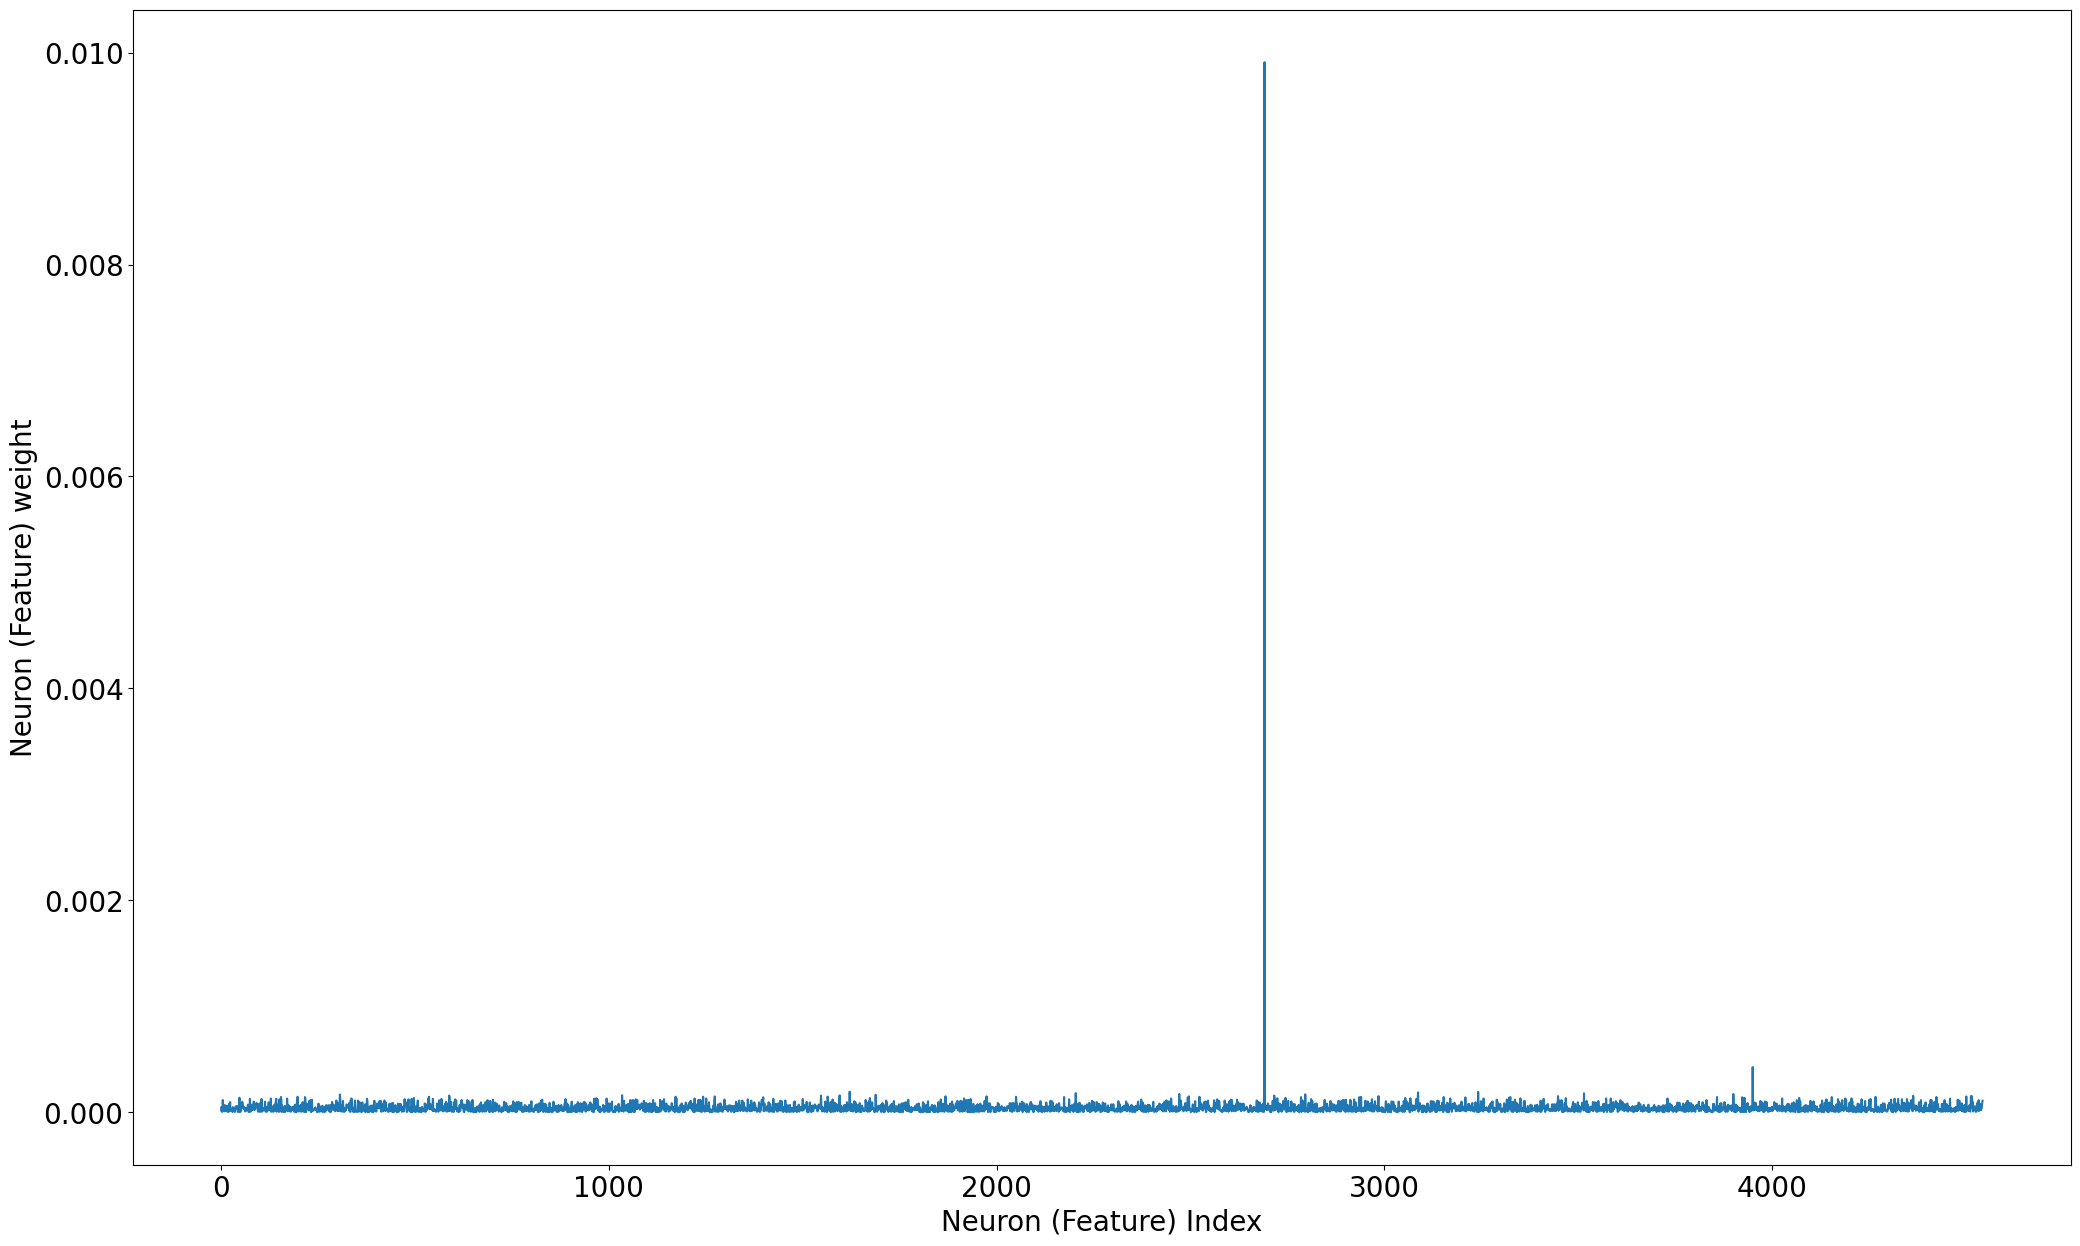

In [33]:
# Do we see any peak?

plt.figure(figsize=(25,15))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.plot(range(input_dim), torch.abs(best_weights[0]).to('cpu').numpy())
plt.xlabel('Neuron (Feature) Index', size=20)
plt.ylabel('Neuron (Feature) weight', size=20)

Text(0, 0.5, 'Neuron (Feature) weight')

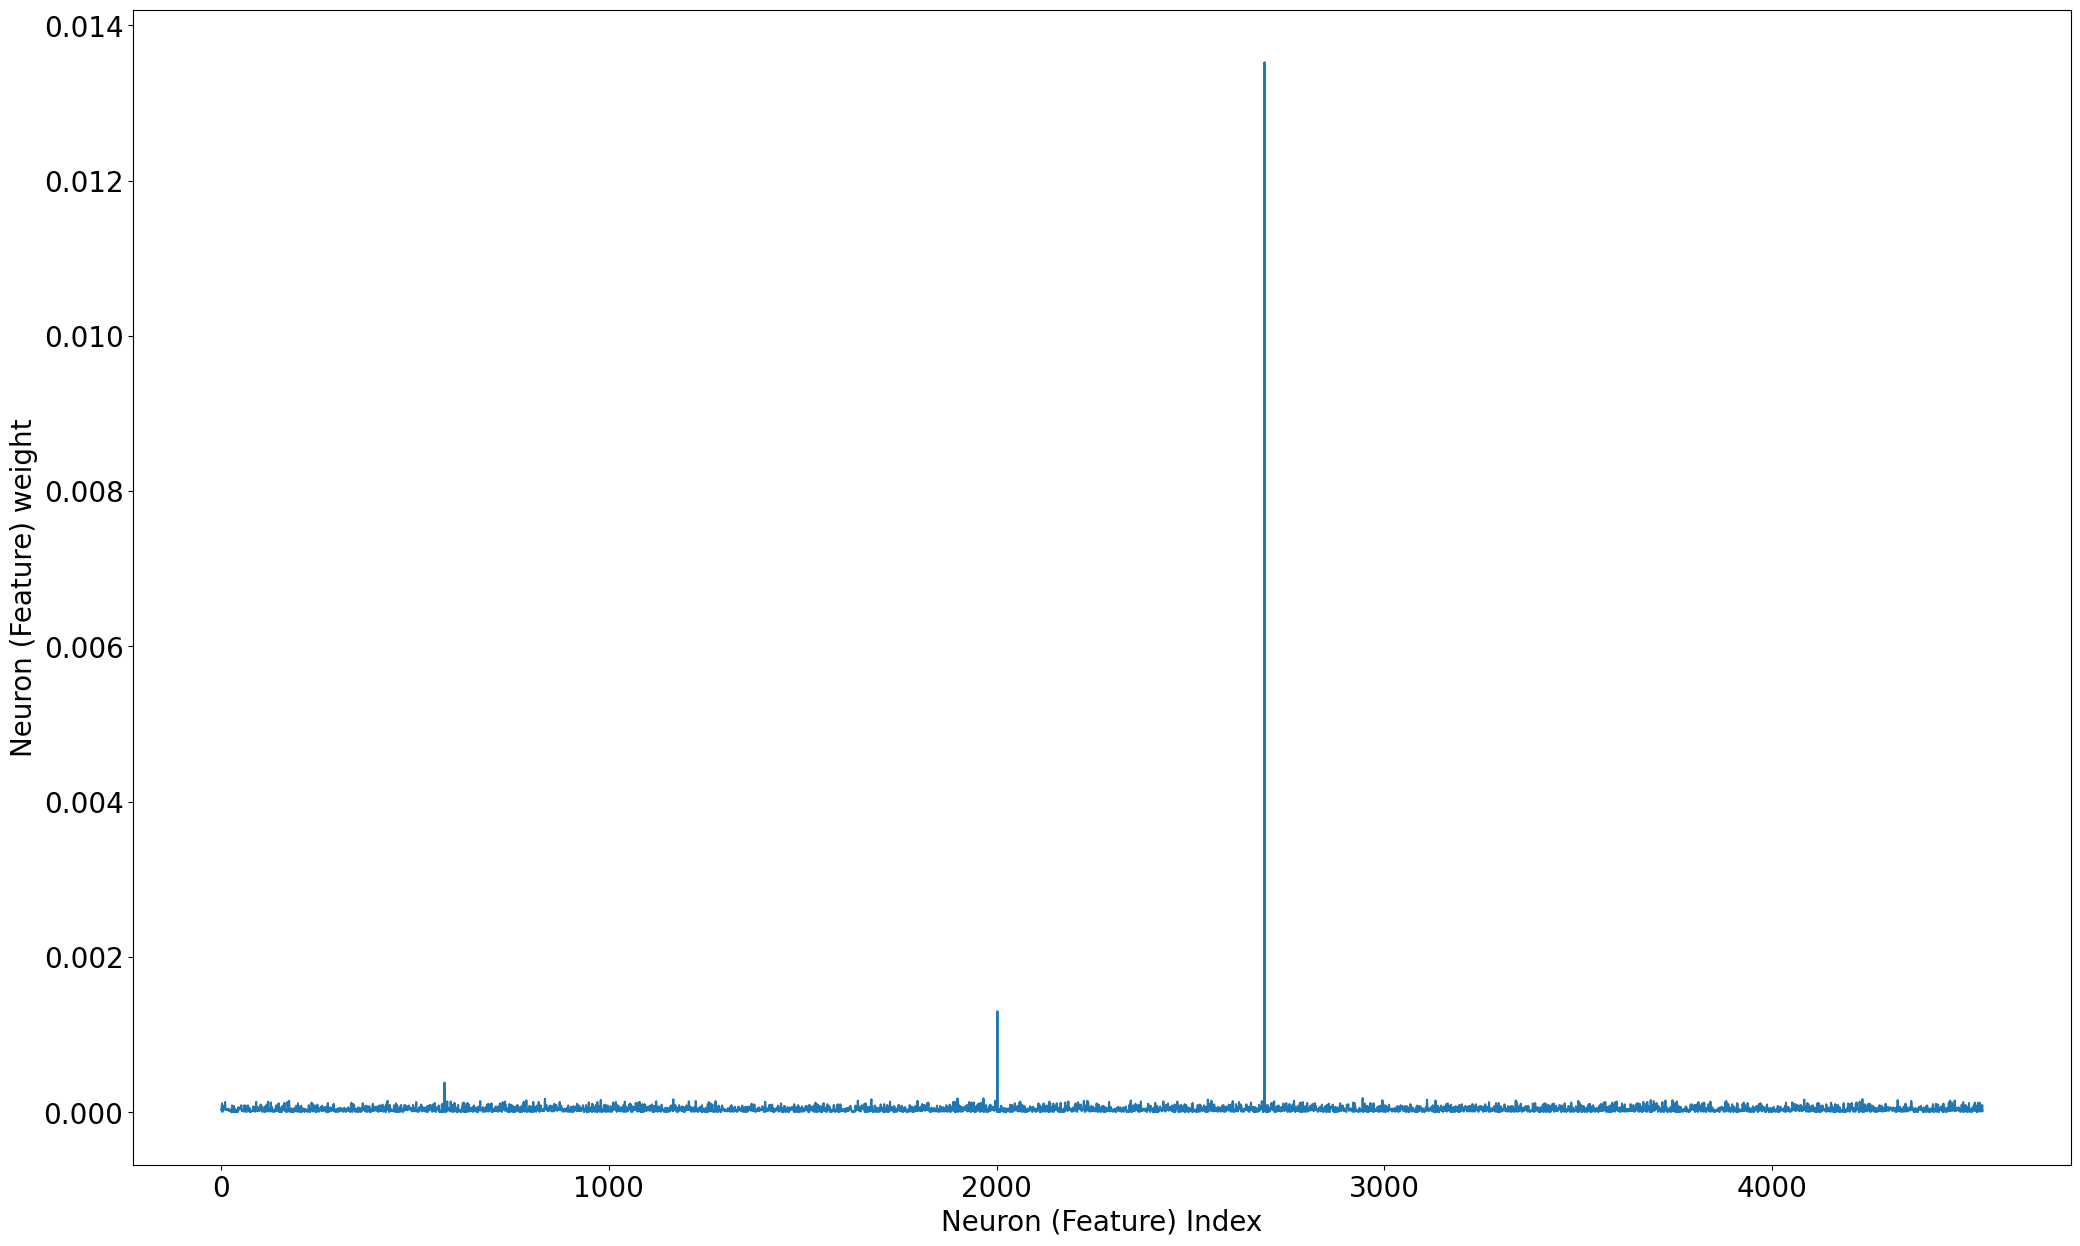

In [34]:
plt.figure(figsize=(25,15))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.plot(range(input_dim), torch.abs(best_weights[1]).to('cpu').numpy())
plt.xlabel('Neuron (Feature) Index', size=20)
plt.ylabel('Neuron (Feature) weight', size=20)